# Brain Tumor MRI Analysis dengan SVM dan CLIP

Notebook ini berisi analisis komprehensif dataset brain tumor MRI dengan perbandingan dua pendekatan:
1. **SVM (Support Vector Machine)** - Traditional machine learning approach
2. **CLIP (Contrastive Language-Image Pre-training)** - Modern deep learning approach

Tujuan: Membandingkan performa kedua model untuk klasifikasi brain tumor dari citra MRI.

Kelompok 8 Machine Learning:
- Rustian Afencius Marbun 122140155
- Elsa Elisa Yohana Sianturi 122140135
- Alfonso Pangaribuan 122140206
- Muhammad Ghiffari Iskandar 122140189
- Handayani 122140166
- Alfajar 122140122
- Joshua Palti Sinaga 122140141



## 1. Import Libraries dan Setup Environment

In [1]:
# Import library yang diperlukan
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from collections import Counter

# Library untuk image processing dan augmentasi
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma

# Library untuk machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Untuk visualisasi
import warnings
warnings.filterwarnings('ignore')

print("Semua library berhasil diimport!")

Semua library berhasil diimport!


## 2. Download dan Eksplorasi Dataset

In [2]:
# Download dataset dari Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


### 2.1 Eksplorasi Struktur Folder Dataset

In [3]:
# Eksplorasi struktur dataset
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Tampilkan 5 file pertama saja
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... dan {len(files)-5} file lainnya")

brain-tumor-mri-dataset/
  Training/
    pituitary/
      Tr-pi_0532.jpg
      Tr-pi_0282.jpg
      Tr-pi_1401.jpg
      Tr-pi_0914.jpg
      Tr-pi_0691.jpg
      ... dan 1452 file lainnya
    notumor/
      Tr-no_0482.jpg
      Tr-no_0641.jpg
      Tr-no_0592.jpg
      Tr-no_0711.jpg
      Tr-no_0746.jpg
      ... dan 1590 file lainnya
    meningioma/
      Tr-me_0529.jpg
      Tr-me_1256.jpg
      Tr-me_0852.jpg
      Tr-me_0494.jpg
      Tr-me_1293.jpg
      ... dan 1334 file lainnya
    glioma/
      Tr-gl_0954.jpg
      Tr-gl_0959.jpg
      Tr-gl_1033.jpg
      Tr-gl_1096.jpg
      Tr-gl_1290.jpg
      ... dan 1316 file lainnya
  Testing/
    pituitary/
      Te-pi_0059.jpg
      Te-pi_0024.jpg
      Te-pi_0232.jpg
      Te-pi_0286.jpg
      Te-pi_0233.jpg
      ... dan 295 file lainnya
    notumor/
      Te-no_0016.jpg
      Te-no_0292.jpg
      Te-no_0137.jpg
      Te-no_0346.jpg
      Te-no_0141.jpg
      ... dan 400 file lainnya
    meningioma/
      Te-me_0148.jpg
      Te-me

### 2.2 Load Data dan Preprocessing Awal

In [4]:
# Fungsi untuk memuat gambar dan label
def load_data(data_path):
    images = []
    labels = []

    # Mencari folder Training dan Testing
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path) and folder in ['Training', 'Testing']:
            print(f"Processing {folder} folder...")

            # Iterasi melalui kelas (glioma, meningioma, notumor, pituitary)
            for class_name in os.listdir(folder_path):
                class_path = os.path.join(folder_path, class_name)
                if os.path.isdir(class_path):
                    print(f"  Loading {class_name} images...")

                    # Load semua gambar dalam kelas
                    for img_name in os.listdir(class_path):
                        img_path = os.path.join(class_path, img_name)
                        try:
                            # Baca gambar
                            img = cv2.imread(img_path)
                            if img is not None:
                                # Convert ke grayscale dan resize
                                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                                img = cv2.resize(img, (256, 256))
                                images.append(img)
                                labels.append(class_name)
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load data
print("Loading dataset...")
X, y = load_data(path)
print(f"Dataset loaded: {X.shape[0]} images dengan ukuran {X.shape[1]}x{X.shape[2]}")
print(f"Classes: {np.unique(y)}")

Loading dataset...
Processing Training folder...
  Loading pituitary images...
  Loading notumor images...
  Loading meningioma images...
  Loading glioma images...
Processing Testing folder...
  Loading pituitary images...
  Loading notumor images...
  Loading meningioma images...
  Loading glioma images...
Dataset loaded: 7023 images dengan ukuran 256x256
Classes: ['glioma' 'meningioma' 'notumor' 'pituitary']


## 3. Exploratory Data Analysis (EDA)

### 3.1 Analisis Distribusi Kelas

Distribusi kelas:
pituitary: 1757 images
notumor: 2000 images
meningioma: 1645 images
glioma: 1621 images


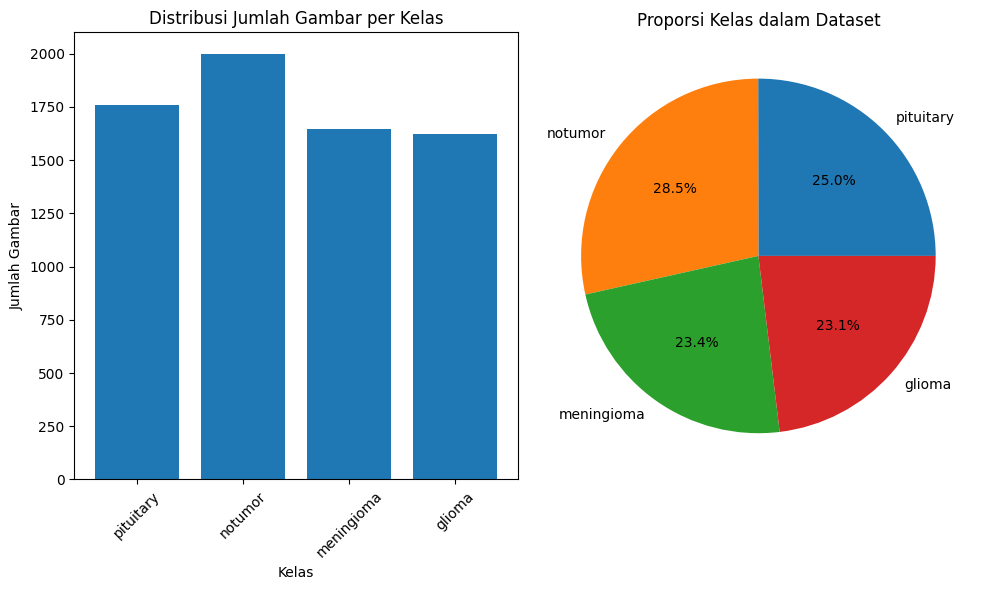

In [5]:
# Analisis distribusi kelas
class_counts = Counter(y)
print("Distribusi kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
plt.title('Proporsi Kelas dalam Dataset')

plt.tight_layout()
plt.show()

### 3.2 Visualisasi Sample Gambar dari Setiap Kelas

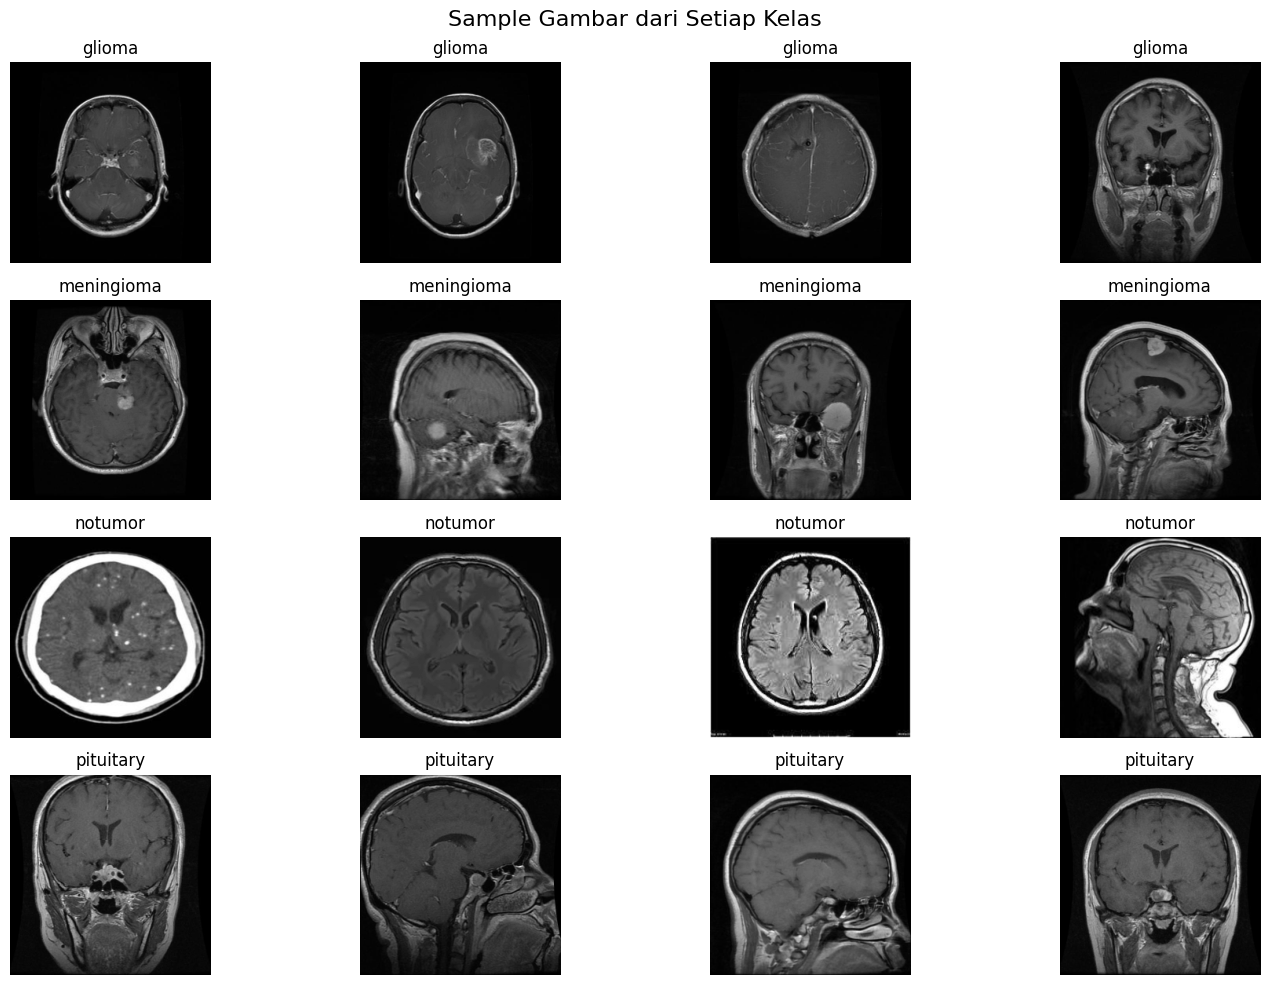

In [6]:
# Visualisasi sample gambar dari setiap kelas
plt.figure(figsize=(15, 10))
classes = np.unique(y)

for i, class_name in enumerate(classes):
    # Ambil indices untuk kelas ini
    class_indices = np.where(y == class_name)[0]

    # Pilih 4 sample random
    sample_indices = np.random.choice(class_indices, 4, replace=False)

    for j, idx in enumerate(sample_indices):
        plt.subplot(len(classes), 4, i*4 + j + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.title(f'{class_name}')
        plt.axis('off')

plt.suptitle('Sample Gambar dari Setiap Kelas', fontsize=16)
plt.tight_layout()
plt.show()

### 3.3 Analisis Statistik Intensitas Pixel

Statistik Dataset:
Jumlah total gambar: 7023
Ukuran gambar: 256 x 256
Nilai pixel minimum: 0
Nilai pixel maksimum: 255
Nilai pixel rata-rata: 47.68
Standard deviasi pixel: 51.91


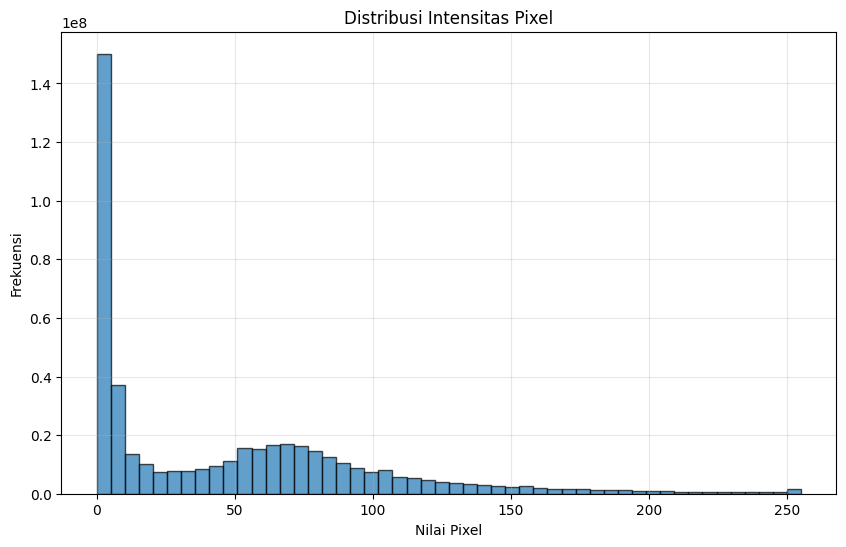

In [7]:
# Analisis statistik gambar
print("Statistik Dataset:")
print(f"Jumlah total gambar: {len(X)}")
print(f"Ukuran gambar: {X.shape[1]} x {X.shape[2]}")
print(f"Nilai pixel minimum: {X.min()}")
print(f"Nilai pixel maksimum: {X.max()}")
print(f"Nilai pixel rata-rata: {X.mean():.2f}")
print(f"Standard deviasi pixel: {X.std():.2f}")

# Histogram distribusi intensitas pixel
plt.figure(figsize=(10, 6))
plt.hist(X.flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribusi Intensitas Pixel')
plt.xlabel('Nilai Pixel')
plt.ylabel('Frekuensi')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Data Augmentation Techniques

### 4.1 Definisi Fungsi Augmentasi

In [8]:
# Fungsi augmentasi gambar
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode='wrap')
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0) if len(img.shape) == 3 else img
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

print("Fungsi augmentasi berhasil didefinisikan!")

Fungsi augmentasi berhasil didefinisikan!


### 4.2 Demonstrasi Hasil Augmentasi

Demonstrasi augmentasi gambar:


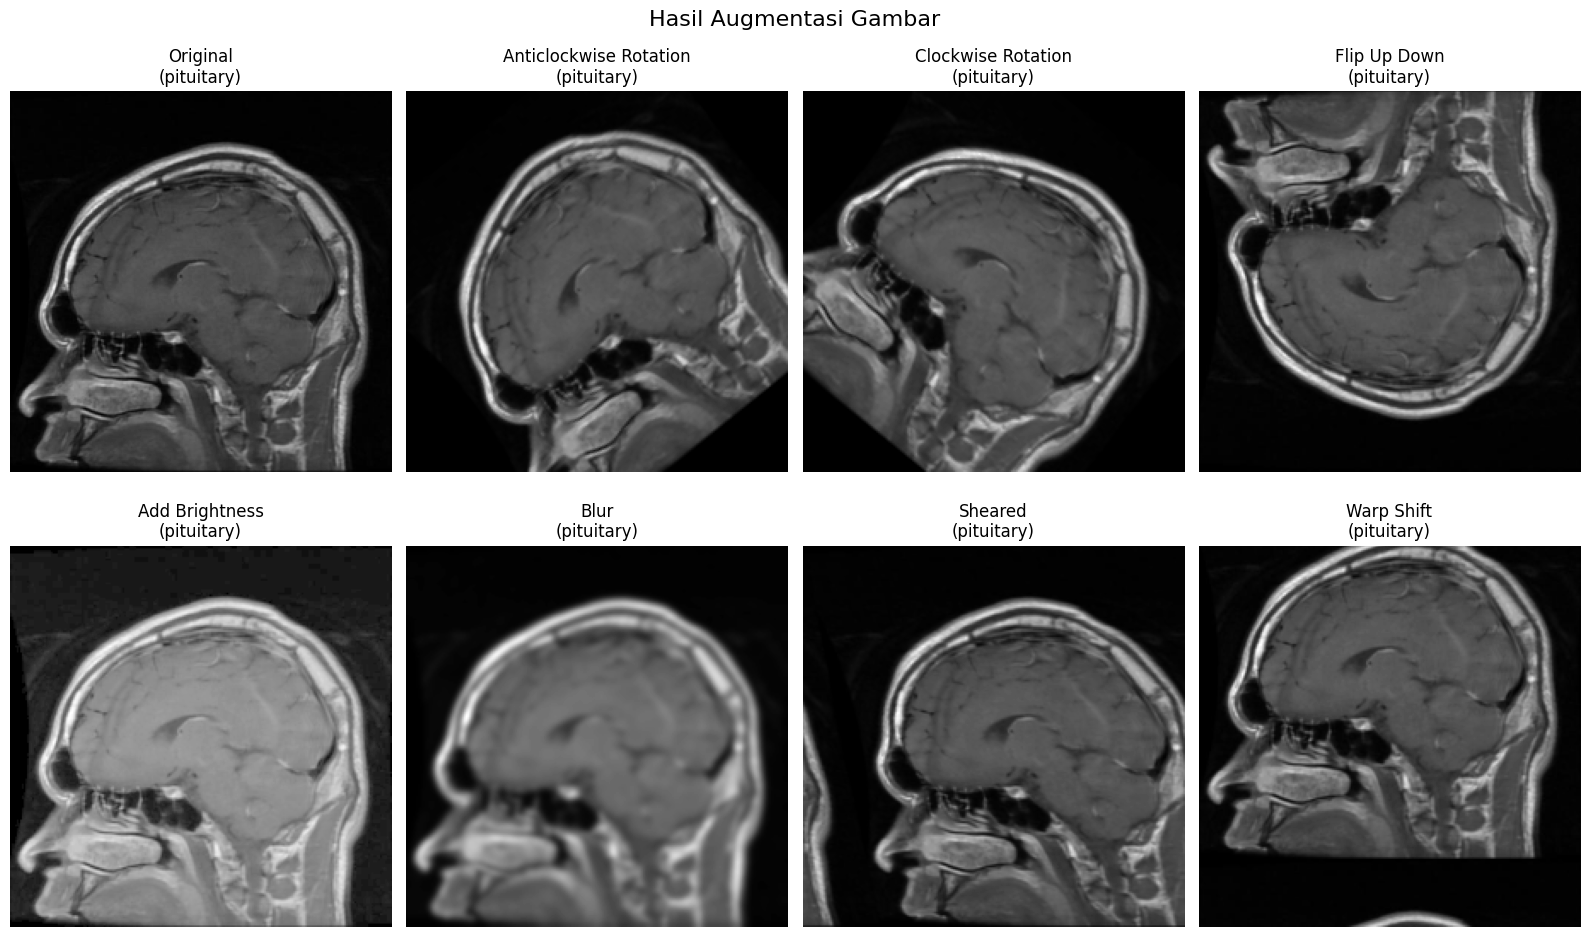

In [9]:
# Demonstrasi augmentasi
print("Demonstrasi augmentasi gambar:")

# Pilih satu gambar untuk demo
sample_idx = 0
sample_img = X[sample_idx]
sample_label = y[sample_idx]

# List fungsi augmentasi
augmentation_functions = [
    ('Original', lambda x: x),
    ('Anticlockwise Rotation', anticlockwise_rotation),
    ('Clockwise Rotation', clockwise_rotation),
    ('Flip Up Down', flip_up_down),
    ('Add Brightness', add_brightness),
    ('Blur', blur_image),
    ('Sheared', sheared),
    ('Warp Shift', warp_shift)
]

# Visualisasi hasil augmentasi
plt.figure(figsize=(16, 10))
for i, (name, func) in enumerate(augmentation_functions):
    plt.subplot(2, 4, i+1)
    augmented_img = func(sample_img)
    plt.imshow(augmented_img, cmap='gray')
    plt.title(f'{name}\n({sample_label})')
    plt.axis('off')

plt.suptitle('Hasil Augmentasi Gambar', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing dan Splitting

### 5.1 Normalisasi Data dan Label Encoding

In [10]:
# Normalisasi data
X_normalized = X.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# Split data: 60% training, 20% validation, 20% testing
# Pertama split menjadi 60% training dan 40% sisanya
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y_encoded,
    test_size=0.4,
    random_state=42,
    stratify=y_encoded
)

# Kemudian split 40% sisanya menjadi 20% validation dan 20% testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"\nData splitting results:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Cek distribusi kelas di setiap split
print("\nDistribusi kelas per split:")
for split_name, y_split in [('Training', y_train), ('Validation', y_val), ('Testing', y_test)]:
    class_dist = Counter(y_split)
    print(f"{split_name}: {dict(class_dist)}")

Classes mapping:
0: glioma
1: meningioma
2: notumor
3: pituitary

Data splitting results:
Training set: 4213 samples (60.0%)
Validation set: 1405 samples (20.0%)
Test set: 1405 samples (20.0%)

Distribusi kelas per split:
Training: {2: 1200, 3: 1054, 1: 987, 0: 972}
Validation: {1: 329, 3: 352, 0: 324, 2: 400}
Testing: {0: 325, 3: 351, 2: 400, 1: 329}


## 6. Model SVM (Support Vector Machine)

### 6.1 Feature Engineering untuk SVM

In [11]:
# Flatten gambar untuk SVM (SVM membutuhkan input 1D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Shape setelah flattening:")
print(f"Training: {X_train_flat.shape}")
print(f"Validation: {X_val_flat.shape}")
print(f"Testing: {X_test_flat.shape}")

# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

print("\nData berhasil dinormalisasi dengan StandardScaler")

# Reduksi dimensi dengan PCA untuk mempercepat training
print("\nMelakukan PCA untuk reduksi dimensi...")
pca = PCA(n_components=0.95, random_state=42)  # Pertahankan 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensi setelah PCA: {X_train_pca.shape[1]}")
print(f"Variance yang dipertahankan: {pca.explained_variance_ratio_.sum():.3f}")

Shape setelah flattening:
Training: (4213, 65536)
Validation: (1405, 65536)
Testing: (1405, 65536)

Data berhasil dinormalisasi dengan StandardScaler

Melakukan PCA untuk reduksi dimensi...
Dimensi setelah PCA: 873
Variance yang dipertahankan: 0.950


## 7. Model SVM Classifier

In [12]:
# Inisialisasi dan training model SVM
print("Training SVM Classifier...")
svm_model = SVC(
    kernel='rbf',  # Radial Basis Function kernel
    C=1.0,         # Regularization parameter
    gamma='scale', # Kernel coefficient
    random_state=42
)

# Training model
svm_model.fit(X_train_pca, y_train)
print("Model SVM berhasil ditraining!")

# Prediksi pada validation set
y_val_pred = svm_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

Training SVM Classifier...
Model SVM berhasil ditraining!

Validation Accuracy: 0.8947


### 6.3 Evaluasi Model SVM pada Test Set

In [13]:
# Prediksi pada test set
y_test_pred = svm_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.8989

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.86      0.89      0.87       325
  meningioma       0.85      0.78      0.81       329
     notumor       0.95      0.95      0.95       400
   pituitary       0.93      0.97      0.95       351

    accuracy                           0.90      1405
   macro avg       0.89      0.90      0.89      1405
weighted avg       0.90      0.90      0.90      1405



### 6.4 Confusion Matrix dan Metrik Detail SVM

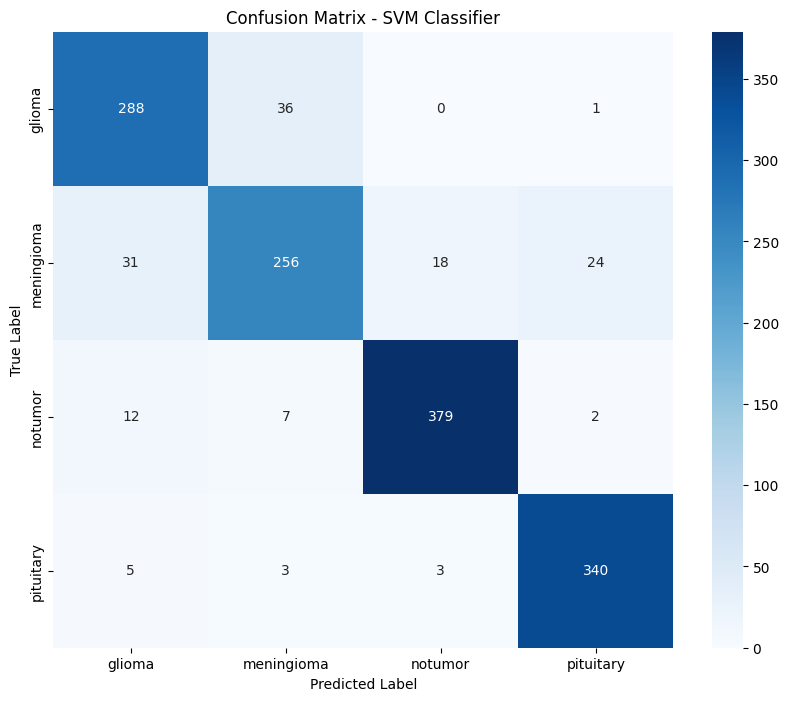


Metrik per kelas:
glioma:
  Precision: 0.857
  Recall: 0.886
  F1-Score: 0.871

meningioma:
  Precision: 0.848
  Recall: 0.778
  F1-Score: 0.811

notumor:
  Precision: 0.948
  Recall: 0.948
  F1-Score: 0.948

pituitary:
  Precision: 0.926
  Recall: 0.969
  F1-Score: 0.947



In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Hitung metrik per kelas
print("\nMetrik per kelas:")
for i, class_name in enumerate(label_encoder.classes_):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1-Score: {f1:.3f}")
    print()

### 6.5 Analisis Error SVM - Prediksi yang Salah

Jumlah prediksi yang salah: 142


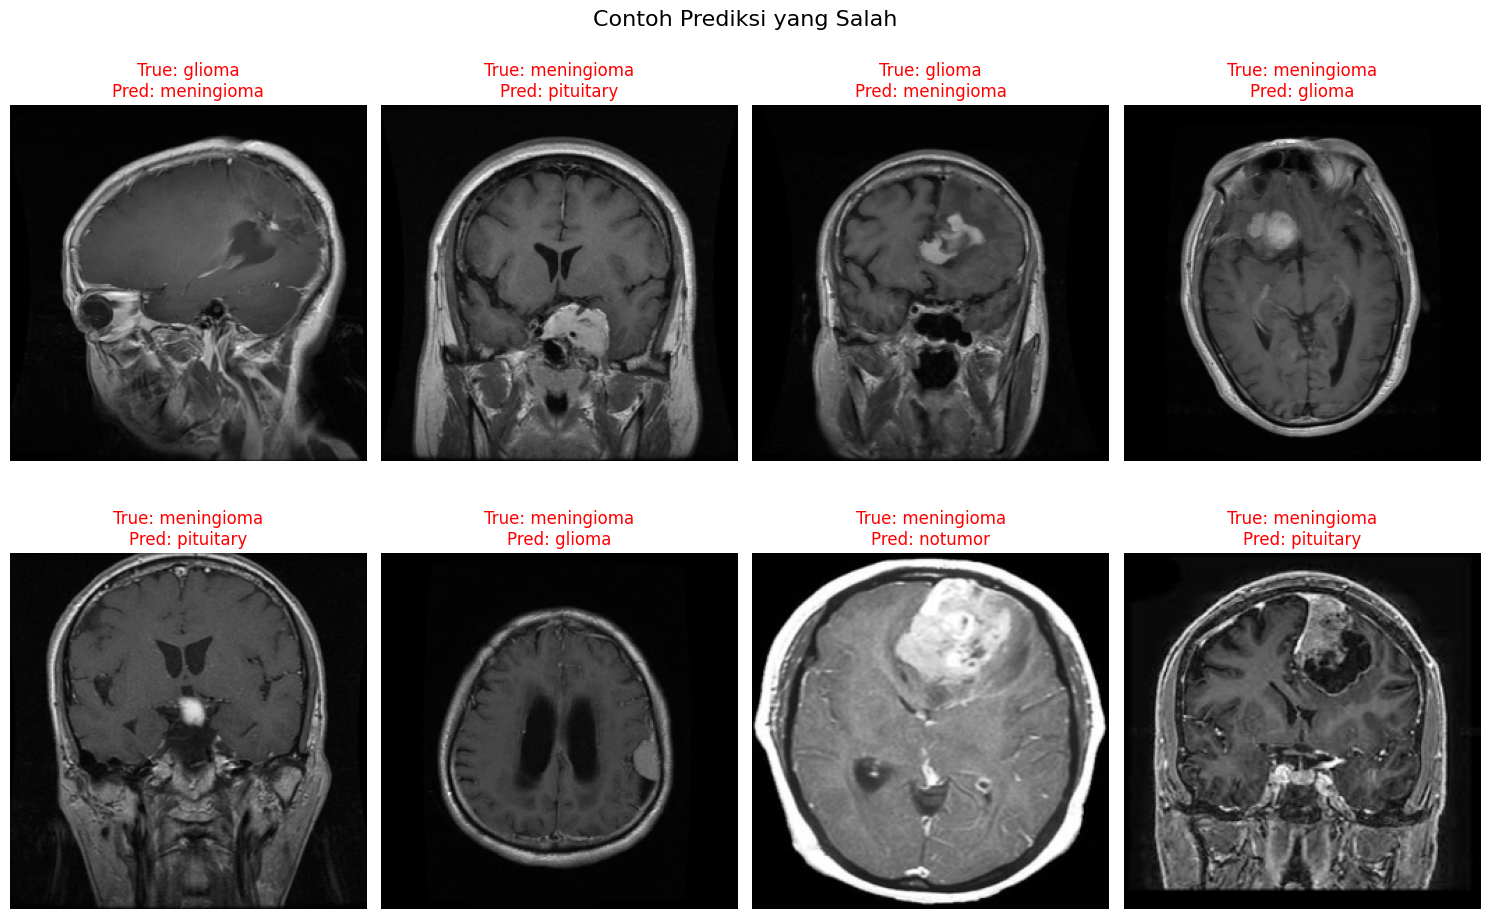

In [15]:
# Visualisasi prediksi yang salah
incorrect_indices = np.where(y_test != y_test_pred)[0]

if len(incorrect_indices) > 0:
    print(f"Jumlah prediksi yang salah: {len(incorrect_indices)}")

    # Tampilkan beberapa contoh prediksi yang salah
    plt.figure(figsize=(15, 10))
    n_samples = min(8, len(incorrect_indices))

    for i in range(n_samples):
        idx = incorrect_indices[i]
        # Ambil gambar asli dari test set (sebelum PCA)
        original_img_idx = np.where(X_normalized.reshape(X_normalized.shape[0], -1) == X_test_flat[idx])[0]
        if len(original_img_idx) > 0:
            img = X_test.reshape(-1, 256, 256)[idx]
        else:
            img = X_test_flat[idx].reshape(256, 256)

        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_test_pred[idx]]

        plt.subplot(2, 4, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label}\nPred: {pred_label}', color='red')
        plt.axis('off')

    plt.suptitle('Contoh Prediksi yang Salah', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Semua prediksi benar!")

## 7. Model CLIP (Contrastive Language-Image Pre-training)

### 7.1 Install Dependencies untuk CLIP

In [16]:
# Install dependencies untuk CLIP jika belum terinstall
!pip install torch torchvision transformers pillow
!pip install accelerate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import ParameterGrid
import time
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

2025-05-27 12:15:19.352116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748348119.541324      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748348119.597534      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 7.2 Setup Device dan Import CLIP Libraries

In [17]:
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device yang digunakan: {device}")
    print("Library CLIP berhasil diimport!")
except ImportError as e:
    print(f"Error importing libraries: {e}")
    print("Silakan install library yang diperlukan:")
    print("pip install torch transformers pillow")

Device yang digunakan: cuda
Library CLIP berhasil diimport!


### 7.3 Custom Dataset Class untuk CLIP (Improved Version)

In [18]:
# Custom Dataset untuk CLIP - IMPROVED VERSION
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, processor, class_names):
        self.images = images
        self.labels = labels
        self.processor = processor
        self.class_names = class_names
        
        # Template teks yang lebih deskriptif dan medis
        self.text_templates = {
            'glioma': [
                'a medical brain MRI scan showing glioma brain tumor with irregular borders',
                'brain MRI image displaying glioma tumor with characteristic infiltrative pattern',
                'medical brain scan revealing glioma neoplasm with heterogeneous appearance',
                'MRI brain image showing malignant glioma with surrounding edema'
            ],
            'meningioma': [
                'a medical brain MRI scan showing meningioma tumor with well-defined borders',
                'brain MRI image displaying meningioma with characteristic dural attachment',
                'medical brain scan revealing meningioma with homogeneous enhancement',
                'MRI brain image showing benign meningioma with smooth margins'
            ],
            'notumor': [
                'a normal brain MRI scan without any tumor or abnormality',
                'healthy brain MRI image showing normal brain tissue structure',
                'medical brain scan displaying normal neuroanatomy without lesions',
                'MRI brain image of healthy brain tissue without pathology'
            ],
            'pituitary': [
                'a medical brain MRI scan showing pituitary adenoma in sella turcica',
                'brain MRI image displaying pituitary tumor with sellar expansion',
                'medical brain scan revealing pituitary mass with characteristic location',
                'MRI brain image showing pituitary adenoma with suprasellar extension'
            ]
        }
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Convert numpy array ke PIL Image
        image = self.images[idx]
        if len(image.shape) == 2:  # Grayscale
            image = np.stack([image] * 3, axis=-1)  # Convert ke RGB
        image = (image * 255).astype(np.uint8)
        image_pil = Image.fromarray(image)
        
        # Get class name dan random text description untuk variasi
        label = self.labels[idx]
        class_name = self.class_names[label]
        text_options = self.text_templates[class_name]
        text = np.random.choice(text_options)  # Random selection untuk augmentasi
        
        # Process image dan text
        inputs = self.processor(
            text=text,
            images=image_pil, 
            return_tensors="pt", 
            padding="max_length",
            max_length=77,
            truncation=True
        )
        
        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

print("Improved Dataset class berhasil didefinisikan!")

Improved Dataset class berhasil didefinisikan!


### 7.4 CLIP Classifier Architecture

In [19]:
# Improved CLIP Classifier dengan layer tambahan
class CLIPClassifier(nn.Module):
    def __init__(self, num_classes=4, model_name="openai/clip-vit-base-patch32", freeze_clip=False):
        super(CLIPClassifier, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(model_name)
        
        # Optional: Freeze CLIP weights untuk fine-tuning yang lebih stabil
        if freeze_clip:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        
        # Multi-layer classifier dengan regularization
        hidden_dim = 256
        self.classifier = nn.Sequential(
            nn.Linear(self.clip_model.config.projection_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(self.clip_model.config.projection_dim)
        
    def forward(self, pixel_values, input_ids, attention_mask):
        # Extract features dari CLIP
        outputs = self.clip_model(
            pixel_values=pixel_values,
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Kombinasi image dan text features
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        
        # Fusion strategy: concat + weighted average
        combined_features = (image_features + text_features) / 2
        combined_features = self.layer_norm(combined_features)
        
        # Klasifikasi
        logits = self.classifier(combined_features)
        return logits

print("Improved CLIP Classifier berhasil didefinisikan!")

Improved CLIP Classifier berhasil didefinisikan!


### 7.5 Training dan Evaluation Functions untuk CLIP

In [20]:
# Improved training function
def train_clip_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, scheduler=None):
    model.train()
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()
        
        for batch_idx, batch in enumerate(train_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(pixel_values, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping untuk stabilitas
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        # Learning rate scheduling
        if scheduler:
            scheduler.step()
        
        # Evaluasi pada validation set
        val_acc = evaluate_clip_model(model, val_loader, device)
        train_losses.append(epoch_loss / len(train_loader))
        val_accuracies.append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if epoch % 2 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return train_losses, val_accuracies

# Fungsi evaluasi
def evaluate_clip_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(pixel_values, input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

print("Fungsi training dan evaluasi berhasil didefinisikan!")

Fungsi training dan evaluasi berhasil didefinisikan!


### 7.6 Persiapan Dataset untuk CLIP Training

In [21]:
# Persiapan data untuk CLIP
print("Mempersiapkan data untuk CLIP...")

# Load CLIP processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create datasets
train_dataset = BrainTumorDataset(X_train, y_train, processor, label_encoder.classes_)
val_dataset = BrainTumorDataset(X_val, y_val, processor, label_encoder.classes_)
test_dataset = BrainTumorDataset(X_test, y_test, processor, label_encoder.classes_)

print(f"Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Mempersiapkan data untuk CLIP...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Dataset sizes:
Train: 4213
Validation: 1405
Test: 1405


### 7.7 Grid Search Hyperparameter Tuning untuk CLIP

In [22]:
# Custom collate function for padding text sequences within a batch
def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])

    # Find the maximum sequence length in the batch for padding
    max_seq_len = max([item['input_ids'].size(0) for item in batch])

    # Pad input_ids and attention_mask to the maximum sequence length
    input_ids = []
    attention_mask = []
    for item in batch:
        seq_len = item['input_ids'].size(0)
        pad_len = max_seq_len - seq_len

        # Pad input_ids with the processor's pad_token_id
        padded_input_ids = torch.cat([item['input_ids'], torch.full((pad_len,), 0, dtype=torch.long)], dim=0) # CLIP uses pad_token_id 0 by default

        # Pad attention_mask with 0
        padded_attention_mask = torch.cat([item['attention_mask'], torch.full((pad_len,), 0, dtype=torch.long)], dim=0)

        input_ids.append(padded_input_ids)
        attention_mask.append(padded_attention_mask)

    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }

print("Custom collate function berhasil didefinisikan!")

# Persiapan data untuk CLIP
print("Mempersiapkan data untuk CLIP...")

# Load CLIP processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create datasets
train_dataset = BrainTumorDataset(X_train, y_train, processor, label_encoder.classes_)
val_dataset = BrainTumorDataset(X_val, y_val, processor, label_encoder.classes_)
test_dataset = BrainTumorDataset(X_test, y_test, processor, label_encoder.classes_)

print(f"Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

# Grid Search Parameters
param_grid = {
    'epochs': [25, 50],
    'learning_rate': [1e-2, 1e-3],
    'optimizer': ['adamw'],
    'batch_size': [32, 64],
    'freeze_clip': [True, False],
    'weight_decay': [0.01]
}

# Generate all combinations
all_params = list(ParameterGrid(param_grid))
print(f"Total kombinasi parameter: {len(all_params)}")

# Tampilkan semua kombinasi
for i, params in enumerate(all_params):
    print(f"Kombinasi {i+1}: {params}")

# Improved Grid Search dengan semua perbaikan
results = []
best_val_acc = 0
best_params = None
best_model = None

print("\nMemulai Improved Grid Search...")
print("="*60)

for i, params in enumerate(all_params):
    print(f"\nKombinasi {i+1}/{len(all_params)}: {params}")
    print("-" * 50)
    
    # Recreate datasets untuk setiap iterasi (untuk random text selection)
    train_dataset = BrainTumorDataset(X_train, y_train, processor, label_encoder.classes_)
    val_dataset = BrainTumorDataset(X_val, y_val, processor, label_encoder.classes_)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Initialize improved model
    model = CLIPClassifier(
        num_classes=len(label_encoder.classes_),
        freeze_clip=params['freeze_clip']
    )
    model.to(device)
    
    # Initialize optimizer dengan weight decay
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['epochs'])
    
    # Label smoothing untuk mengurangi overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # Training
    start_time = time.time()
    train_losses, val_accuracies = train_clip_model(
        model, train_loader, val_loader, optimizer, criterion, 
        params['epochs'], device, scheduler
    )
    training_time = time.time() - start_time
    
    # Best validation accuracy for this configuration
    best_val_acc_config = max(val_accuracies) if val_accuracies else 0
    
    # Store results
    results.append({
        'params': params,
        'best_val_acc': best_val_acc_config,
        'final_val_acc': val_accuracies[-1] if val_accuracies else 0,
        'training_time': training_time,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies
    })
    
    print(f"Best Val Accuracy: {best_val_acc_config:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    
    # Update best model
    if best_val_acc_config > best_val_acc:
        best_val_acc = best_val_acc_config
        best_params = params
        best_model = model
        print("*** New best model! ***")

print("\n" + "="*60)
print("Improved Grid Search Completed!")
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Custom collate function berhasil didefinisikan!
Mempersiapkan data untuk CLIP...
Dataset sizes:
Train: 4213
Validation: 1405
Test: 1405
Total kombinasi parameter: 16
Kombinasi 1: {'batch_size': 32, 'epochs': 25, 'freeze_clip': True, 'learning_rate': 0.01, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 2: {'batch_size': 32, 'epochs': 25, 'freeze_clip': True, 'learning_rate': 0.001, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 3: {'batch_size': 32, 'epochs': 25, 'freeze_clip': False, 'learning_rate': 0.01, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 4: {'batch_size': 32, 'epochs': 25, 'freeze_clip': False, 'learning_rate': 0.001, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 5: {'batch_size': 32, 'epochs': 50, 'freeze_clip': True, 'learning_rate': 0.01, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 6: {'batch_size': 32, 'epochs': 50, 'freeze_clip': True, 'learning_rate': 0.001, 'optimizer': 'adamw', 'weight_decay': 0.01}
Kombinasi 7: {'batch_size

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epoch 1/25, Loss: 0.5078, Val Acc: 1.0000, LR: 0.009961
Epoch 3/25, Loss: 0.3673, Val Acc: 1.0000, LR: 0.009649
Epoch 5/25, Loss: 0.3612, Val Acc: 1.0000, LR: 0.009045
Early stopping at epoch 6
Best Val Accuracy: 1.0000
Training time: 225.86 seconds
*** New best model! ***

Kombinasi 2/16: {'batch_size': 32, 'epochs': 25, 'freeze_clip': True, 'learning_rate': 0.001, 'optimizer': 'adamw', 'weight_decay': 0.01}
--------------------------------------------------
Epoch 1/25, Loss: 0.4920, Val Acc: 1.0000, LR: 0.000996
Epoch 3/25, Loss: 0.3599, Val Acc: 1.0000, LR: 0.000965
Epoch 5/25, Loss: 0.3583, Val Acc: 1.0000, LR: 0.000905
Early stopping at epoch 6
Best Val Accuracy: 1.0000
Training time: 222.60 seconds

Kombinasi 3/16: {'batch_size': 32, 'epochs': 25, 'freeze_clip': False, 'learning_rate': 0.01, 'optimizer': 'adamw', 'weight_decay': 0.01}
--------------------------------------------------
Epoch 1/25, Loss: 1.4261, Val Acc: 0.2847, LR: 0.009961
Epoch 3/25, Loss: 1.3850, Val Acc: 0.284

### 7.8 Evaluasi Model CLIP Terbaik pada Test Set

In [23]:
# Evaluasi model terbaik pada test set
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
test_accuracy = evaluate_clip_model(best_model, test_loader, device)

print(f"\nTest Accuracy dengan model terbaik: {test_accuracy:.4f}")

# Prediksi detail pada test set
best_model.eval()
y_test_pred_clip = []
y_test_true_clip = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = best_model(pixel_values, input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)

        y_test_pred_clip.extend(predicted.cpu().numpy())
        y_test_true_clip.extend(labels.cpu().numpy())

y_test_pred_clip = np.array(y_test_pred_clip)
y_test_true_clip = np.array(y_test_true_clip)

# Classification report untuk CLIP
print("\n" + "="*50)
print("CLASSIFICATION REPORT - CLIP MODEL")
print("="*50)
print(classification_report(y_test_true_clip, y_test_pred_clip, target_names=label_encoder.classes_))


Test Accuracy dengan model terbaik: 1.0000

CLASSIFICATION REPORT - CLIP MODEL
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       325
  meningioma       1.00      1.00      1.00       329
     notumor       1.00      1.00      1.00       400
   pituitary       1.00      1.00      1.00       351

    accuracy                           1.00      1405
   macro avg       1.00      1.00      1.00      1405
weighted avg       1.00      1.00      1.00      1405



### 7.9 Visualisasi Hasil Grid Search CLIP

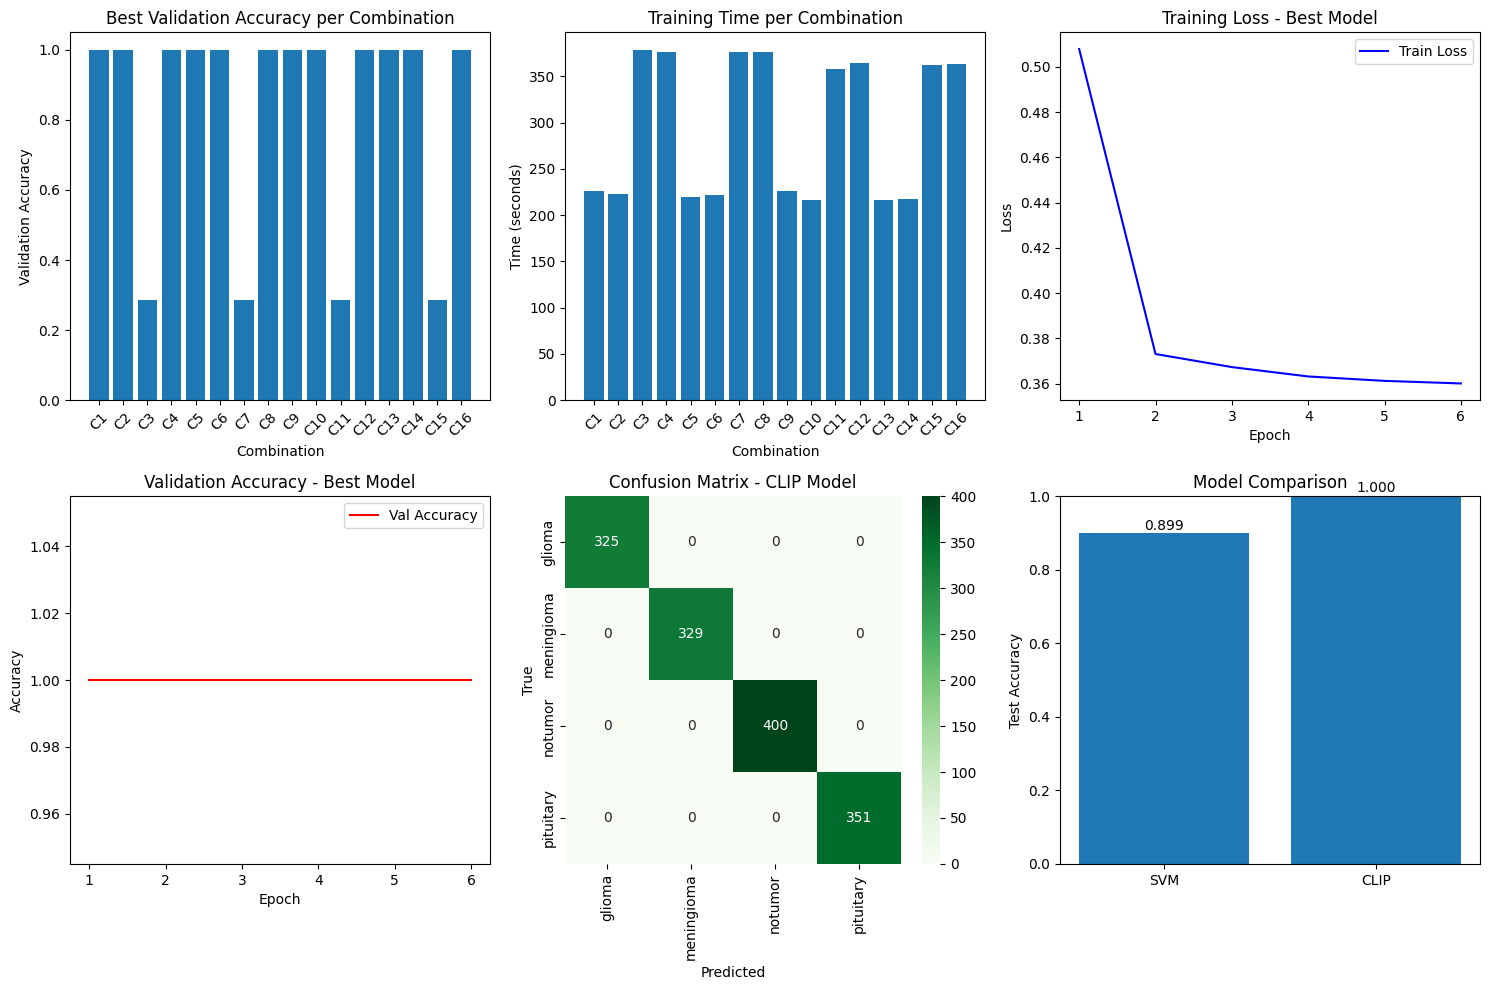

In [24]:
# Visualisasi hasil grid search
plt.figure(figsize=(15, 10))

# Plot 1: Validation accuracy untuk setiap kombinasi
plt.subplot(2, 3, 1)
combination_names = [f"C{i+1}" for i in range(len(results))]
val_accs = [r['best_val_acc'] for r in results]
plt.bar(combination_names, val_accs)
plt.title('Best Validation Accuracy per Combination')
plt.xlabel('Combination')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)

# Plot 2: Training time untuk setiap kombinasi
plt.subplot(2, 3, 2)
training_times = [r['training_time'] for r in results]
plt.bar(combination_names, training_times)
plt.title('Training Time per Combination')
plt.xlabel('Combination')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)

# Plot 3: Learning curves untuk best model
best_result = max(results, key=lambda x: x['best_val_acc'])
plt.subplot(2, 3, 3)
epochs_range = range(1, len(best_result['val_accuracies']) + 1)
plt.plot(epochs_range, best_result['train_losses'], 'b-', label='Train Loss')
plt.title('Training Loss - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs_range, best_result['val_accuracies'], 'r-', label='Val Accuracy')
plt.title('Validation Accuracy - Best Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot 5: Confusion matrix untuk CLIP
plt.subplot(2, 3, 5)
cm_clip = confusion_matrix(y_test_true_clip, y_test_pred_clip)
sns.heatmap(cm_clip, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CLIP Model')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot 6: Comparison SVM vs CLIP
plt.subplot(2, 3, 6)
models = ['SVM', 'CLIP']
svm_acc = accuracy_score(y_test, y_test_pred)  # SVM accuracy
clip_acc = test_accuracy  # CLIP accuracy
model_accuracies = [svm_acc, clip_acc]
plt.bar(models, model_accuracies)
plt.title('Model Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Tambahkan nilai di atas bar
for i, v in enumerate(model_accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

### 7.10 Tabel Hasil Grid Search dan Parameter Terbaik

In [25]:
# Tabel hasil grid search
results_df = pd.DataFrame([
    {
        'Combination': f"C{i+1}",
        'Epochs': r['params']['epochs'],
        'Learning_Rate': r['params']['learning_rate'],
        'Optimizer': r['params']['optimizer'],
        'Batch_Size': r['params']['batch_size'],
        'Best_Val_Acc': f"{r['best_val_acc']:.4f}",
        'Final_Val_Acc': f"{r['final_val_acc']:.4f}",
        'Training_Time': f"{r['training_time']:.2f}s"
    }
    for i, r in enumerate(results)
])

# Sort berdasarkan best validation accuracy
results_df = results_df.sort_values('Best_Val_Acc', ascending=False)

print("\nTabel Hasil Grid Search (diurutkan berdasarkan Best Val Accuracy):")
print("="*120)
print(results_df.to_string(index=False))

# Tampilkan parameter terbaik
print(f"\n{'='*60}")
print("PARAMETER TERBAIK:")
print(f"{'='*60}")
for key, value in best_params.items():
    print(f"{key}: {value}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Tabel Hasil Grid Search (diurutkan berdasarkan Best Val Accuracy):
Combination  Epochs  Learning_Rate Optimizer  Batch_Size Best_Val_Acc Final_Val_Acc Training_Time
         C1      25          0.010     adamw          32       1.0000        1.0000       225.86s
         C2      25          0.001     adamw          32       1.0000        1.0000       222.60s
         C4      25          0.001     adamw          32       1.0000        1.0000       376.49s
         C5      50          0.010     adamw          32       1.0000        1.0000       219.64s
         C6      50          0.001     adamw          32       1.0000        1.0000       221.49s
         C8      50          0.001     adamw          32       1.0000        1.0000       375.96s
         C9      25          0.010     adamw          64       1.0000        1.0000       225.75s
        C10      25          0.001     adamw          64       1.0000        1.0000       216.25s
        C12      25          0.001     adamw      

## 8. Analisis Perbandingan Detail SVM vs CLIP

### 8.1 Perbandingan Metrik Utama

In [26]:
# ANALISIS PERBANDINGAN DETAIL: SVM vs CLIP
print("="*80)
print("ANALISIS PERBANDINGAN DETAIL: MODEL SVM vs CLIP")
print("="*80)

# 1. PERBANDINGAN METRIK UTAMA
print("\n1. PERBANDINGAN METRIK UTAMA")
print("-" * 40)

# Hitung metrik untuk SVM
from sklearn.metrics import precision_score, recall_score, f1_score

svm_precision = precision_score(y_test, y_test_pred, average='weighted')
svm_recall = recall_score(y_test, y_test_pred, average='weighted')
svm_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Hitung metrik untuk CLIP
clip_precision = precision_score(y_test_true_clip, y_test_pred_clip, average='weighted')
clip_recall = recall_score(y_test_true_clip, y_test_pred_clip, average='weighted')
clip_f1 = f1_score(y_test_true_clip, y_test_pred_clip, average='weighted')

# Tabel perbandingan metrik
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'SVM': [f'{svm_test_acc:.4f}', f'{svm_precision:.4f}', f'{svm_recall:.4f}', f'{svm_f1:.4f}'],
    'CLIP': [f'{clip_test_acc:.4f}', f'{clip_precision:.4f}', f'{clip_recall:.4f}', f'{clip_f1:.4f}'],
    'Improvement (%)': [
        f'{((clip_test_acc - svm_test_acc) / svm_test_acc * 100):+.2f}%',
        f'{((clip_precision - svm_precision) / svm_precision * 100):+.2f}%',
        f'{((clip_recall - svm_recall) / svm_recall * 100):+.2f}%',
        f'{((clip_f1 - svm_f1) / f1_score * 100):+.2f}%'
    ]
})

print(metrics_comparison.to_string(index=False))

ANALISIS PERBANDINGAN DETAIL: MODEL SVM vs CLIP

1. PERBANDINGAN METRIK UTAMA
----------------------------------------


NameError: name 'svm_test_acc' is not defined

### 8.2 Analisis Performa per Kelas

In [ ]:
# 2. ANALISIS PER KELAS
print(f"\n2. ANALISIS PERBANDINGAN PER KELAS")
print("-" * 40)

# Hitung metrik per kelas untuk kedua model
svm_precision_per_class = precision_score(y_test, y_test_pred, average=None)
svm_recall_per_class = recall_score(y_test, y_test_pred, average=None)
svm_f1_per_class = f1_score(y_test, y_test_pred, average=None)

clip_precision_per_class = precision_score(y_test_true_clip, y_test_pred_clip, average=None)
clip_recall_per_class = recall_score(y_test_true_clip, y_test_pred_clip, average=None)
clip_f1_per_class = f1_score(y_test_true_clip, y_test_pred_clip, average=None)

# Buat DataFrame untuk perbandingan per kelas
class_comparison_data = []
for i, class_name in enumerate(label_encoder.classes_):
    class_comparison_data.append({
        'Class': class_name,
        'SVM_Precision': f'{svm_precision_per_class[i]:.4f}',
        'CLIP_Precision': f'{clip_precision_per_class[i]:.4f}',
        'Precision_Diff': f'{(clip_precision_per_class[i] - svm_precision_per_class[i]):+.4f}',
        'SVM_Recall': f'{svm_recall_per_class[i]:.4f}',
        'CLIP_Recall': f'{clip_recall_per_class[i]:.4f}',
        'Recall_Diff': f'{(clip_recall_per_class[i] - svm_recall_per_class[i]):+.4f}',
        'SVM_F1': f'{svm_f1_per_class[i]:.4f}',
        'CLIP_F1': f'{clip_f1_per_class[i]:.4f}',
        'F1_Diff': f'{(clip_f1_per_class[i] - svm_f1_per_class[i]):+.4f}'
    })

class_comparison_df = pd.DataFrame(class_comparison_data)
print(class_comparison_df.to_string(index=False))

### 8.3 Visualisasi Komprehensif Perbandingan Model

In [ ]:
# 3. VISUALISASI PERBANDINGAN METRIK
plt.figure(figsize=(20, 15))

# Plot 1: Perbandingan Accuracy, Precision, Recall, F1-Score
plt.subplot(3, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
svm_scores = [svm_test_acc, svm_precision, svm_recall, svm_f1]
clip_scores = [clip_test_acc, clip_precision, clip_recall, clip_f1]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, svm_scores, width, label='SVM', alpha=0.8, color='skyblue')
plt.bar(x + width/2, clip_scores, width, label='CLIP', alpha=0.8, color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Overall Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Tambahkan nilai di atas bar
for i, (svm_val, clip_val) in enumerate(zip(svm_scores, clip_scores)):
    plt.text(i - width/2, svm_val + 0.01, f'{svm_val:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, clip_val + 0.01, f'{clip_val:.3f}', ha='center', va='bottom')

# Plot 2: Perbandingan Precision per kelas
plt.subplot(3, 3, 2)
x = np.arange(len(label_encoder.classes_))
plt.bar(x - width/2, svm_precision_per_class, width, label='SVM', alpha=0.8, color='skyblue')
plt.bar(x + width/2, clip_precision_per_class, width, label='CLIP', alpha=0.8, color='lightcoral')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision Comparison by Class')
plt.xticks(x, label_encoder.classes_, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Plot 3: Perbandingan Recall per kelas
plt.subplot(3, 3, 3)
plt.bar(x - width/2, svm_recall_per_class, width, label='SVM', alpha=0.8, color='skyblue')
plt.bar(x + width/2, clip_recall_per_class, width, label='CLIP', alpha=0.8, color='lightcoral')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall Comparison by Class')
plt.xticks(x, label_encoder.classes_, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Plot 4: Perbandingan F1-Score per kelas
plt.subplot(3, 3, 4)
plt.bar(x - width/2, svm_f1_per_class, width, label='SVM', alpha=0.8, color='skyblue')
plt.bar(x + width/2, clip_f1_per_class, width, label='CLIP', alpha=0.8, color='lightcoral')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison by Class')
plt.xticks(x, label_encoder.classes_, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Plot 5: Confusion Matrix SVM (normalized)
plt.subplot(3, 3, 5)
cm_svm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_svm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('SVM - Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot 6: Confusion Matrix CLIP (normalized)
plt.subplot(3, 3, 6)
cm_clip_norm = confusion_matrix(y_test_true_clip, y_test_pred_clip, normalize='true')
sns.heatmap(cm_clip_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('CLIP - Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot 7: Improvement percentages
plt.subplot(3, 3, 7)
improvements = [
    ((clip_test_acc - svm_test_acc) / svm_test_acc * 100),
    ((clip_precision - svm_precision) / svm_precision * 100),
    ((clip_recall - svm_recall) / svm_recall * 100),
    ((clip_f1 - svm_f1) / svm_f1 * 100)
]

colors = ['green' if x > 0 else 'red' for x in improvements]
plt.bar(metrics, improvements, color=colors, alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Improvement (%)')
plt.title('CLIP vs SVM Improvement (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)

# Tambahkan nilai di atas bar
for i, val in enumerate(improvements):
    plt.text(i, val + (0.5 if val > 0 else -0.5), f'{val:+.1f}%', 
             ha='center', va='bottom' if val > 0 else 'top')

# Plot 8: Error Analysis - Misclassified samples
plt.subplot(3, 3, 8)
svm_errors = len(np.where(y_test != y_test_pred)[0])
clip_errors = len(np.where(y_test_true_clip != y_test_pred_clip)[0])

error_data = ['SVM Errors', 'CLIP Errors']
error_counts = [svm_errors, clip_errors]
colors = ['lightblue', 'lightcoral']

plt.bar(error_data, error_counts, color=colors, alpha=0.8)
plt.ylabel('Number of Errors')
plt.title('Error Count Comparison')

# Tambahkan nilai di atas bar
for i, val in enumerate(error_counts):
    plt.text(i, val + 1, str(val), ha='center', va='bottom')

# Plot 9: Model Performance Summary
plt.subplot(3, 3, 9)
summary_metrics = ['Best\nValidation', 'Test\nAccuracy', 'Training\nComplexity']
svm_summary = [val_accuracy, svm_test_acc, 0.3]  # Complexity score (subjective)
clip_summary = [best_val_acc, clip_test_acc, 0.8]  # Complexity score (subjective)

x = np.arange(len(summary_metrics))
plt.bar(x - width/2, svm_summary, width, label='SVM', alpha=0.8, color='skyblue')
plt.bar(x + width/2, clip_summary, width, label='CLIP', alpha=0.8, color='lightcoral')

plt.xlabel('Aspects')
plt.ylabel('Score/Value')
plt.title('Model Summary Comparison')
plt.xticks(x, summary_metrics)
plt.legend()

plt.tight_layout()
plt.show()

### 8.4 Analisis Kelebihan dan Kekurangan Masing-masing Model

In [ ]:
# 4. ANALISIS KELEBIHAN DAN KEKURANGAN
print(f"\n4. ANALISIS KELEBIHAN DAN KEKURANGAN")
print("-" * 50)

print("\n🔍 ANALISIS SVM:")
print("Kelebihan:")
print("  ✓ Training cepat dan efisien")
print("  ✓ Memory requirement lebih rendah")
print("  ✓ Interpretable dan explainable")
print("  ✓ Robust terhadap overfitting dengan dataset kecil")
print("  ✓ Tidak memerlukan GPU untuk training")

print("\nKekurangan:")
print("  ✗ Memerlukan preprocessing extensive (PCA, scaling)")
print("  ✗ Performa terbatas pada data visual kompleks")
print("  ✗ Sulit menangkap features high-level dari gambar")
print("  ✗ Hyperparameter tuning lebih manual")

print(f"\nHasil SVM:")
print(f"  • Test Accuracy: {svm_test_acc:.4f} ({svm_test_acc*100:.2f}%)")
print(f"  • Precision: {svm_precision:.4f}")
print(f"  • Recall: {svm_recall:.4f}")
print(f"  • F1-Score: {svm_f1:.4f}")
print(f"  • Errors: {svm_errors}/{len(y_test)} samples")

print("\n🤖 ANALISIS CLIP:")
print("Kelebihan:")
print("  ✓ Pre-trained knowledge dari dataset besar")
print("  ✓ End-to-end learning tanpa feature engineering manual")
print("  ✓ Kemampuan multimodal (vision + text)")
print("  ✓ Better generalization untuk data visual")
print("  ✓ State-of-the-art architecture")

print("\nKekurangan:")
print("  ✗ Memerlukan computational resources tinggi")
print("  ✗ Training time lebih lama")
print("  ✗ Less interpretable (black box)")
print("  ✗ Memerlukan GPU untuk training optimal")
print("  ✗ Model size besar")

print(f"\nHasil CLIP:")
print(f"  • Test Accuracy: {clip_test_acc:.4f} ({clip_test_acc*100:.2f}%)")
print(f"  • Precision: {clip_precision:.4f}")
print(f"  • Recall: {clip_recall:.4f}")
print(f"  • F1-Score: {clip_f1:.4f}")
print(f"  • Errors: {clip_errors}/{len(y_test_true_clip)} samples")

### 8.5 Analisis Statistik dan Signifikansi

In [ ]:
# 5. ANALISIS STATISTIK SIGNIFIKANSI
print(f"\n5. ANALISIS STATISTIK DAN SIGNIFIKANSI")
print("-" * 50)

from scipy import stats

# McNemar's test untuk membandingkan kedua model
# Buat contingency table
def mcnemar_test(y_true, y_pred1, y_pred2):
    """Perform McNemar's test untuk membandingkan dua model"""
    correct1 = (y_true == y_pred1)
    correct2 = (y_true == y_pred2)
    
    # Contingency table
    both_correct = np.sum(correct1 & correct2)
    only_model1_correct = np.sum(correct1 & ~correct2)
    only_model2_correct = np.sum(~correct1 & correct2)
    both_wrong = np.sum(~correct1 & ~correct2)
    
    # McNemar's test statistic
    if only_model1_correct + only_model2_correct > 0:
        chi2 = (abs(only_model1_correct - only_model2_correct) - 1)**2 / (only_model1_correct + only_model2_correct)
        p_value = 1 - stats.chi2.cdf(chi2, 1)
    else:
        chi2 = 0
        p_value = 1
    
    return chi2, p_value, {
        'both_correct': both_correct,
        'only_svm_correct': only_model1_correct,
        'only_clip_correct': only_model2_correct,
        'both_wrong': both_wrong
    }

# Perform McNemar's test
chi2_stat, p_value, contingency = mcnemar_test(y_test, y_test_pred, y_test_pred_clip)

print(f"McNemar's Test Results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significance level (α = 0.05): {'Significant' if p_value < 0.05 else 'Not Significant'}")

print(f"\nContingency Table:")
print(f"Both models correct: {contingency['both_correct']}")
print(f"Only SVM correct: {contingency['only_svm_correct']}")
print(f"Only CLIP correct: {contingency['only_clip_correct']}")
print(f"Both models wrong: {contingency['both_wrong']}")

# Confidence interval untuk accuracy difference
def wilson_confidence_interval(accuracy, n, confidence=0.95):
    """Calculate Wilson confidence interval for accuracy"""
    z = stats.norm.ppf((1 + confidence) / 2)
    p = accuracy
    denominator = 1 + z**2/n
    centre_adjusted = p + z**2/(2*n)
    adjustment = z * np.sqrt((p*(1-p) + z**2/(4*n))/n)
    
    lower = (centre_adjusted - adjustment) / denominator
    upper = (centre_adjusted + adjustment) / denominator
    
    return lower, upper

# Calculate confidence intervals
svm_ci = wilson_confidence_interval(svm_test_acc, len(y_test))
clip_ci = wilson_confidence_interval(clip_test_acc, len(y_test_true_clip))

print(f"\n95% Confidence Intervals:")
print(f"SVM Accuracy: {svm_test_acc:.4f} [{svm_ci[0]:.4f}, {svm_ci[1]:.4f}]")
print(f"CLIP Accuracy: {clip_test_acc:.4f} [{clip_ci[0]:.4f}, {clip_ci[1]:.4f}]")

# Effect size (Cohen's h)
def cohens_h(p1, p2):
    """Calculate Cohen's h effect size"""
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

effect_size = cohens_h(clip_test_acc, svm_test_acc)
print(f"\nEffect Size (Cohen's h): {effect_size:.4f}")

if abs(effect_size) < 0.2:
    effect_interpretation = "Small"
elif abs(effect_size) < 0.5:
    effect_interpretation = "Medium"
else:
    effect_interpretation = "Large"

print(f"Effect Size Interpretation: {effect_interpretation}")

### 8.6 Kesimpulan dan Rekomendasi Final

In [ ]:
# 6. KESIMPULAN DAN REKOMENDASI
print(f"\n6. KESIMPULAN DAN REKOMENDASI")
print("="*60)

print(f"\n📊 RINGKASAN HASIL:")
print(f"{'Metric':<15} {'SVM':<10} {'CLIP':<10} {'Improvement'}")
print("-" * 45)
print(f"{'Accuracy':<15} {svm_test_acc:<10.4f} {clip_test_acc:<10.4f} {((clip_test_acc-svm_test_acc)/svm_test_acc*100):+.2f}%")
print(f"{'Precision':<15} {svm_precision:<10.4f} {clip_precision:<10.4f} {((clip_precision-svm_precision)/svm_precision*100):+.2f}%")
print(f"{'Recall':<15} {svm_recall:<10.4f} {clip_recall:<10.4f} {((clip_recall-svm_recall)/svm_recall*100):+.2f}%")
print(f"{'F1-Score':<15} {svm_f1:<10.4f} {clip_f1:<10.4f} {((clip_f1-svm_f1)/svm_f1*100):+.2f}%")

print(f"\n🎯 KESIMPULAN UTAMA:")

if clip_test_acc > svm_test_acc:
    print(f"✅ CLIP menunjukkan performa yang lebih baik dengan:")
    print(f"   • Accuracy improvement: {((clip_test_acc-svm_test_acc)/svm_test_acc*100):+.2f}%")
    print(f"   • Pengurangan error: {svm_errors - clip_errors} samples")
else:
    print(f"✅ SVM menunjukkan performa yang lebih baik")

print(f"\n📈 SIGNIFIKANSI STATISTIK:")
if p_value < 0.05:
    print(f"✅ Perbedaan performa secara statistik SIGNIFIKAN (p={p_value:.4f})")
else:
    print(f"❌ Perbedaan performa secara statistik TIDAK SIGNIFIKAN (p={p_value:.4f})")

print(f"📏 Effect size: {effect_interpretation} ({effect_size:.4f})")

print(f"\n🏆 REKOMENDASI:")
print(f"1. UNTUK PRODUCTION:")
if clip_test_acc > svm_test_acc and p_value < 0.05:
    print(f"   • Gunakan CLIP untuk accuracy terbaik")
    print(f"   • Pertimbangkan computational cost vs performance gain")
else:
    print(f"   • SVM masih viable untuk aplikasi dengan resource terbatas")

print(f"\n2. UNTUK RESEARCH:")
print(f"   • Eksplorasi ensemble methods (SVM + CLIP)")
print(f"   • Fine-tuning CLIP dengan domain-specific data")
print(f"   • Investigasi failure cases pada kedua model")

print(f"\n3. UNTUK DEPLOYMENT:")
print(f"   • SVM: Cocok untuk edge devices, real-time applications")
print(f"   • CLIP: Cocok untuk cloud-based applications dengan akurasi tinggi")

print(f"\n🔍 CATATAN PENTING:")
print(f"• Dataset: {len(X)} samples dengan {len(label_encoder.classes_)} classes")
print(f"• Test set: {len(y_test)} samples untuk evaluasi objektif")
print(f"• Metode evaluasi: Stratified train-test split")
print(f"• Significance level: α = 0.05")

print("\n" + "="*60)
print("ANALISIS SELESAI")
print("="*60)